Google Drive Link https://drive.google.com/drive/u/1/folders/1ZBLHK8FbtRVrK3xNzIdcnmNFbInrHN83 \\
where the recorded video and the datasets used in part two can be found \\
* Submitted by: Waisullah Yousofi
* Roll Number: 22D0382

In [103]:
# importing the libraries used
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import sqlite3
pd.set_option('display.max_columns', None)#it enables the environment to show all the columns. None means, we don't specify the maximum number of columns to be shown.

#1. Part One:
Check out the City of Los Angeles public data sources and test the hypothesis that the statistics of
“affordable housing projects” (government housing for low-income people) in a ZIP code has a relation to
the health inspection scores of the restaurants in that ZIP code.

# a) Download csv files


In [104]:
# downloading through Linux wget command
!wget https://data.lacity.org/api/views/29fd-3paw/rows.csv?accessType=DOWNLOAD

restaurantdf = pd.read_csv('rows.csv?accessType=DOWNLOAD')# reading the downloaded dataset in a pandas dataframe

In [105]:
!wget https://data.lacity.org/api/views/mymu-zi3s/rows.csv?accessType=DOWNLOAD
housedf= pd.read_csv('rows.csv?accessType=DOWNLOAD.1')

# b) Perform EDA on the two files


#### i. Check if the data types are as expected, else convert them

In [106]:
restaurantdf.head()#show the first 5 rows without using print() function for better readability

,serial_number,activity_date,facility_name,score,grade,service_code,service_description,employee_id,facility_address,facility_city,facility_id,facility_state,facility_zip,owner_id,owner_name,pe_description,program_element_pe,program_name,program_status,record_id
0,DAJ00E07B,12/29/2017 12:00:00 AM,HABITAT COFFEE SHOP,95,A,1,ROUTINE INSPECTION,EE0000923,3708 N EAGLE ROCK BLVD,LOS ANGELES,FA0170465,CA,90065,OW0178123,GLASSELL COFFEE SHOP LLC,RESTAURANT (0-30) SEATS MODERATE RISK,1631,HABITAT COFFEE SHOP,ACTIVE,PR0160774
1,DAQOKRFZB,12/29/2017 12:00:00 AM,REILLY'S,92,A,1,ROUTINE INSPECTION,EE0000633,100 WORLD WAY # 120,LOS ANGELES,FA0244690,CA,90045,OW0208441,"AREAS SKYVIEW LAX JV, LLC",RESTAURANT (0-30) SEATS MODERATE RISK,1631,REILLY'S,ACTIVE,PR0193026
2,DASJI4LUR,12/29/2017 12:00:00 AM,STREET CHURROS,93,A,1,ROUTINE INSPECTION,EE0000835,6801 HOLLYWOOD BLVD # 253,LOS ANGELES,FA0224109,CA,90028,OW0228670,"STREETCHURROS, INC",RESTAURANT (0-30) SEATS LOW RISK,1630,STREET CHURROS,ACTIVE,PR0179282
3,DA40LU5AT,12/29/2017 12:00:00 AM,TRINITI ECHO PARK,94,A,1,ROUTINE INSPECTION,EE0000923,1814 W SUNSET BLVD,LOS ANGELES,FA0252528,CA,90026-3227,OW0246287,AMERICAN HOSPITALITY,RESTAURANT (0-30) SEATS MODERATE RISK,1631,TRINITI ECHO PARK,ACTIVE,PR0201836
4,DAXV2RMYC,12/29/2017 12:00:00 AM,POLLEN,94,A,1,ROUTINE INSPECTION,EE0000923,2100 ECHO PARK AVE,LOS ANGELES,FA0252789,CA,90026,OW0246479,"POLLEN AND PASTRY , LLC",RESTAURANT (0-30) SEATS MODERATE RISK,1631,POLLEN,ACTIVE,PR0202148


In [107]:
restaurantdf.dtypes#to show the data type of each column

,0
serial_number,object
activity_date,object
facility_name,object
score,int64
grade,object
service_code,int64
service_description,object
employee_id,object
facility_address,object
facility_city,object


In [108]:
#we need only the year part because it should be the same as that of in-service column of housedf.
# we could do in other ways too like index based
restaurantdf["activity_date"] = pd.to_datetime(restaurantdf["activity_date"])#we cannot directly convert an object of type date to a numeric
restaurantdf["activity_date"] = restaurantdf["activity_date"].dt.year

<ipython-input-108-b1b5913b463f>:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  restaurantdf["activity_date"] = pd.to_datetime(restaurantdf["activity_date"])#we cannot directly convert an object of type date to a numeric


In [109]:
restaurantdf.dtypes#to cross check

,0
serial_number,object
activity_date,int32
facility_name,object
score,int64
grade,object
service_code,int64
service_description,object
employee_id,object
facility_address,object
facility_city,object


In [110]:
housedf.dtypes#check

,0
APN,int64
PROJECT NUMBER,object
NAME,object
DEVELOPMENT STAGE,object
CONSTRUCTION TYPE,object
SITE ADDRESS,object
SITE COUNCIL DISTRICT,int64
SITE #,int64
SITE COMMUNITY,object
SITE UNITS,int64


In [111]:
#we need the year in terms of numeric
housedf["IN-SERVICE DATE"] = pd.to_numeric(housedf["IN-SERVICE DATE"], errors='coerce')#coercing errors to NaN the cases when the object is 0
housedf = housedf.dropna(subset=["IN-SERVICE DATE"])#0 which was in the form of Nan is dropped
housedf["IN-SERVICE DATE"] = housedf["IN-SERVICE DATE"].astype(int)# to numeric integer

<ipython-input-111-0fd1fde5176c>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  housedf["IN-SERVICE DATE"] = housedf["IN-SERVICE DATE"].astype(int)# to numeric integer


In [112]:
housedf.dtypes#cross check the data types

,0
APN,int64
PROJECT NUMBER,object
NAME,object
DEVELOPMENT STAGE,object
CONSTRUCTION TYPE,object
SITE ADDRESS,object
SITE COUNCIL DISTRICT,int64
SITE #,int64
SITE COMMUNITY,object
SITE UNITS,int64


#### ii. Check for missing values, then decide to either remove those rows, or fill an imputed value

In [113]:
restaurantdf.isnull().sum().sort_values()#aggregates the null values of each column and shows sorted

,0
serial_number,0
program_element_pe,0
pe_description,0
owner_name,0
owner_id,0
facility_zip,0
facility_state,0
facility_id,0
program_status,0
facility_city,0


In [114]:
print(len(restaurantdf))# length of the dataframe

67573


* we drop the columns with null values, rather than imputing them.
* Because, as far as our problem statement is concerned we have enough samples to make conclusions. Hence, droppnig them won't put us in significant disadvantage side.
* for the column such as "program_name", there are too many of them which we can replace with a fixed value such as "Not Specified" [1] . We can do so because we may interested to visualize this column and at the same time we don't want to loss data of other potential features for our probem statement.


In [115]:
restaurantdf = restaurantdf.drop(columns = "program_name")# dropping the "program_name" because it has the sames values which "facility_name" column has

In [116]:
restaurantdf.dropna(inplace=True)# drop the null values

In [117]:
restaurantdf.isnull().sum().sort_values()# cross check the null values of the data frame

,0
serial_number,0
program_element_pe,0
pe_description,0
owner_name,0
owner_id,0
facility_zip,0
facility_state,0
facility_id,0
program_status,0
facility_city,0


In [118]:
housedf.isnull().sum().sort_values()# checking the null values of housedf data frame

,0
APN,0
SITE LONGITUDE,0
DATE STAMP,0
PROJECT SUMMARY URL,0
PHOTO,0
IN-SERVICE DATE,0
TDC,0
TAX EXEMPT CONDUIT BOND,0
LEVERAGE,0
SITE LATITUDE,0


Except the column "HOUSING TYPE" which we are interested for visualization, we safely drop the remaining columns with null values.Because, as Prof.Amit sethi also mentioned, we don't need them for our problem of hypothesis testing, as they are not potential features to keep.
Moreover, each of them has significant null values which we don't want drop the rows. Rather dropping those columns are prefered here.


In [119]:
housedf = housedf.drop(columns=["SITE COMMUNITY","DEVELOPER","DEVELOPER","MANAGEMENT COMPANY", "CONTACT PHONE","JOBS","CONTRACT NUMBERS","CONSTRUCTION TYPE"])#columns with great number of null values to be dropped

In [120]:
housedf["HOUSING TYPE"].fillna("Not Specified", inplace=True)

In [121]:
housedf.isnull().sum().sort_values()# cross check

,0
APN,0
SITE LONGITUDE,0
DATE STAMP,0
PROJECT SUMMARY URL,0
PHOTO,0
IN-SERVICE DATE,0
TDC,0
TAX EXEMPT CONDUIT BOND,0
LEVERAGE,0
LAHD FUNDED,0


#### iii. Check for unexpected entries in certain columns. Correct them if necessary and feasible.


In [122]:
def correctSpaces(df, column_name):# function takes a dataframe and a column of it as parameter and checks if space exist in that column.
  for value in df[column_name]:# loop through each value of the column passed
    if value.isspace():# checks the value equals to a space
      print(f"Space found in column '{column_name}' and the correspond row is dropped!")# print this message
      df = df[df[column_name] !=' ']# consider only non-space values of that column
  return df# return the cleaned data frame

In [123]:
def checkUniqueEntries(df, column_name):#function takes a dataframe and a list of columns as parameters, and returns unique entries of the passed columns
  for column in column_name:# loop through each column
    print(f"\nUnique entries in column '{column}':")
    print(np.unique(df[column].astype(str)))# np.unique() only find the unique entires which of either of type int or str.

In [124]:
columns_to_check1 = ["score", "grade", "service_description", "facility_city"]
checkUniqueEntries(restaurantdf, columns_to_check1)# checks the unique entries of the specified columns


Unique entries in column 'score':
['100' '64' '65' '66' '67' '68' '70' '71' '72' '73' '74' '75' '76' '77'
 '78' '79' '80' '81' '82' '83' '84' '85' '86' '87' '88' '89' '90' '91'
 '92' '93' '94' '95' '96' '97' '98' '99']

Unique entries in column 'grade':
[' ' 'A' 'B' 'C']

Unique entries in column 'service_description':
['OWNER INITIATED ROUTINE INSPECT.' 'ROUTINE INSPECTION']

Unique entries in column 'facility_city':
['LOS ANGELES']


In [125]:
#we need to remove space entries from the grade column and it cannot be imputed either. Apart from it being a single entry
restaurantdf[restaurantdf["grade"]==" "]

,serial_number,activity_date,facility_name,score,grade,service_code,service_description,employee_id,facility_address,facility_city,facility_id,facility_state,facility_zip,owner_id,owner_name,pe_description,program_element_pe,program_status,record_id
34297,DAVTNZVG3,2015,THREE BEARS BAR-B-Q,65,,1,ROUTINE INSPECTION,EE0000958,11916 S FIGUEROA ST,LOS ANGELES,FA0002898,CA,90061,OW0001713,"ADAMS,HERMAN L",RESTAURANT (0-30) SEATS MODERATE RISK,1631,INACTIVE,PR0023624


In [126]:
restaurantdf = correctSpaces(restaurantdf, "grade")# drop the space

Space found in column 'grade' and the correspond row is dropped!


In [127]:
np.unique(restaurantdf["grade"])# cross check if the space is removed

array(['A', 'B', 'C'], dtype=object)

In [128]:
# if there are any duplicate entries
restaurantdf[restaurantdf.duplicated()]

,serial_number,activity_date,facility_name,score,grade,service_code,service_description,employee_id,facility_address,facility_city,facility_id,facility_state,facility_zip,owner_id,owner_name,pe_description,program_element_pe,program_status,record_id


In [129]:
housing_columns = ["HOUSING TYPE","DEVELOPMENT STAGE"]#columns to expect unexpected values

In [130]:
checkUniqueEntries(housedf, housing_columns)


Unique entries in column 'HOUSING TYPE':
['AT-RISK' 'FAMILY' 'LARGE FAMILY / WAIVER REQUIRED' 'Not Specified'
 'SENIORS' 'SPECIAL NEEDS' 'SRO']

Unique entries in column 'DEVELOPMENT STAGE':
['Development' 'In-Service']


In [131]:
np.unique(restaurantdf["facility_zip"])
#90001-1002 shoud be normalized into 90001
#some zipcodes are stored as a range. we split them based on "-" and then pick the first zip code, 0th index.

array(['90001', '90001-1002', '90001-1127', ..., '91602', '91604',
       '92880'], dtype=object)

In [132]:
print(restaurantdf["facility_zip"].str.split("-"))#

0              [90065]
1              [90045]
2              [90028]
3        [90026, 3227]
4              [90026]
             ...      
67568          [90012]
67569          [90018]
67570          [90011]
67571          [90025]
67572          [90063]
Name: facility_zip, Length: 67569, dtype: object


In [31]:
restaurantdf["facility_zip"] = restaurantdf["facility_zip"].str.split("-").str[0]# first we convert to str because object does not have split function.
restaurantdf["facility_zip"]

,facility_zip
0,90065
1,90045
2,90028
3,90026
4,90026
...,...
67568,90012
67569,90018
67570,90011
67571,90025


In [32]:
# [2]:
def extract_numeric_suffix(address):
  """
  Extracts the last 5 numeric characters from an address string.

  Args:
    address: The address string.

  Returns:
    The last 5 numeric characters if found, otherwise "nondigit".
  """
  suffix = address[-5:]#from last 5 characters till the end
  if suffix.isdigit():#a function of string
    return suffix
  else:
    return "nondigit"

housedf["zip_code"] = housedf["SITE ADDRESS"].apply(extract_numeric_suffix)# apply keyword is used call the function for all the values

In [33]:
housedf["zip_code"]# cross check

,zip_code
0,90017
1,90016
2,90011
3,90043
4,90026
...,...
590,90037
591,90012
592,90011
593,90033


#### iv. Plot some graphs to understand the data

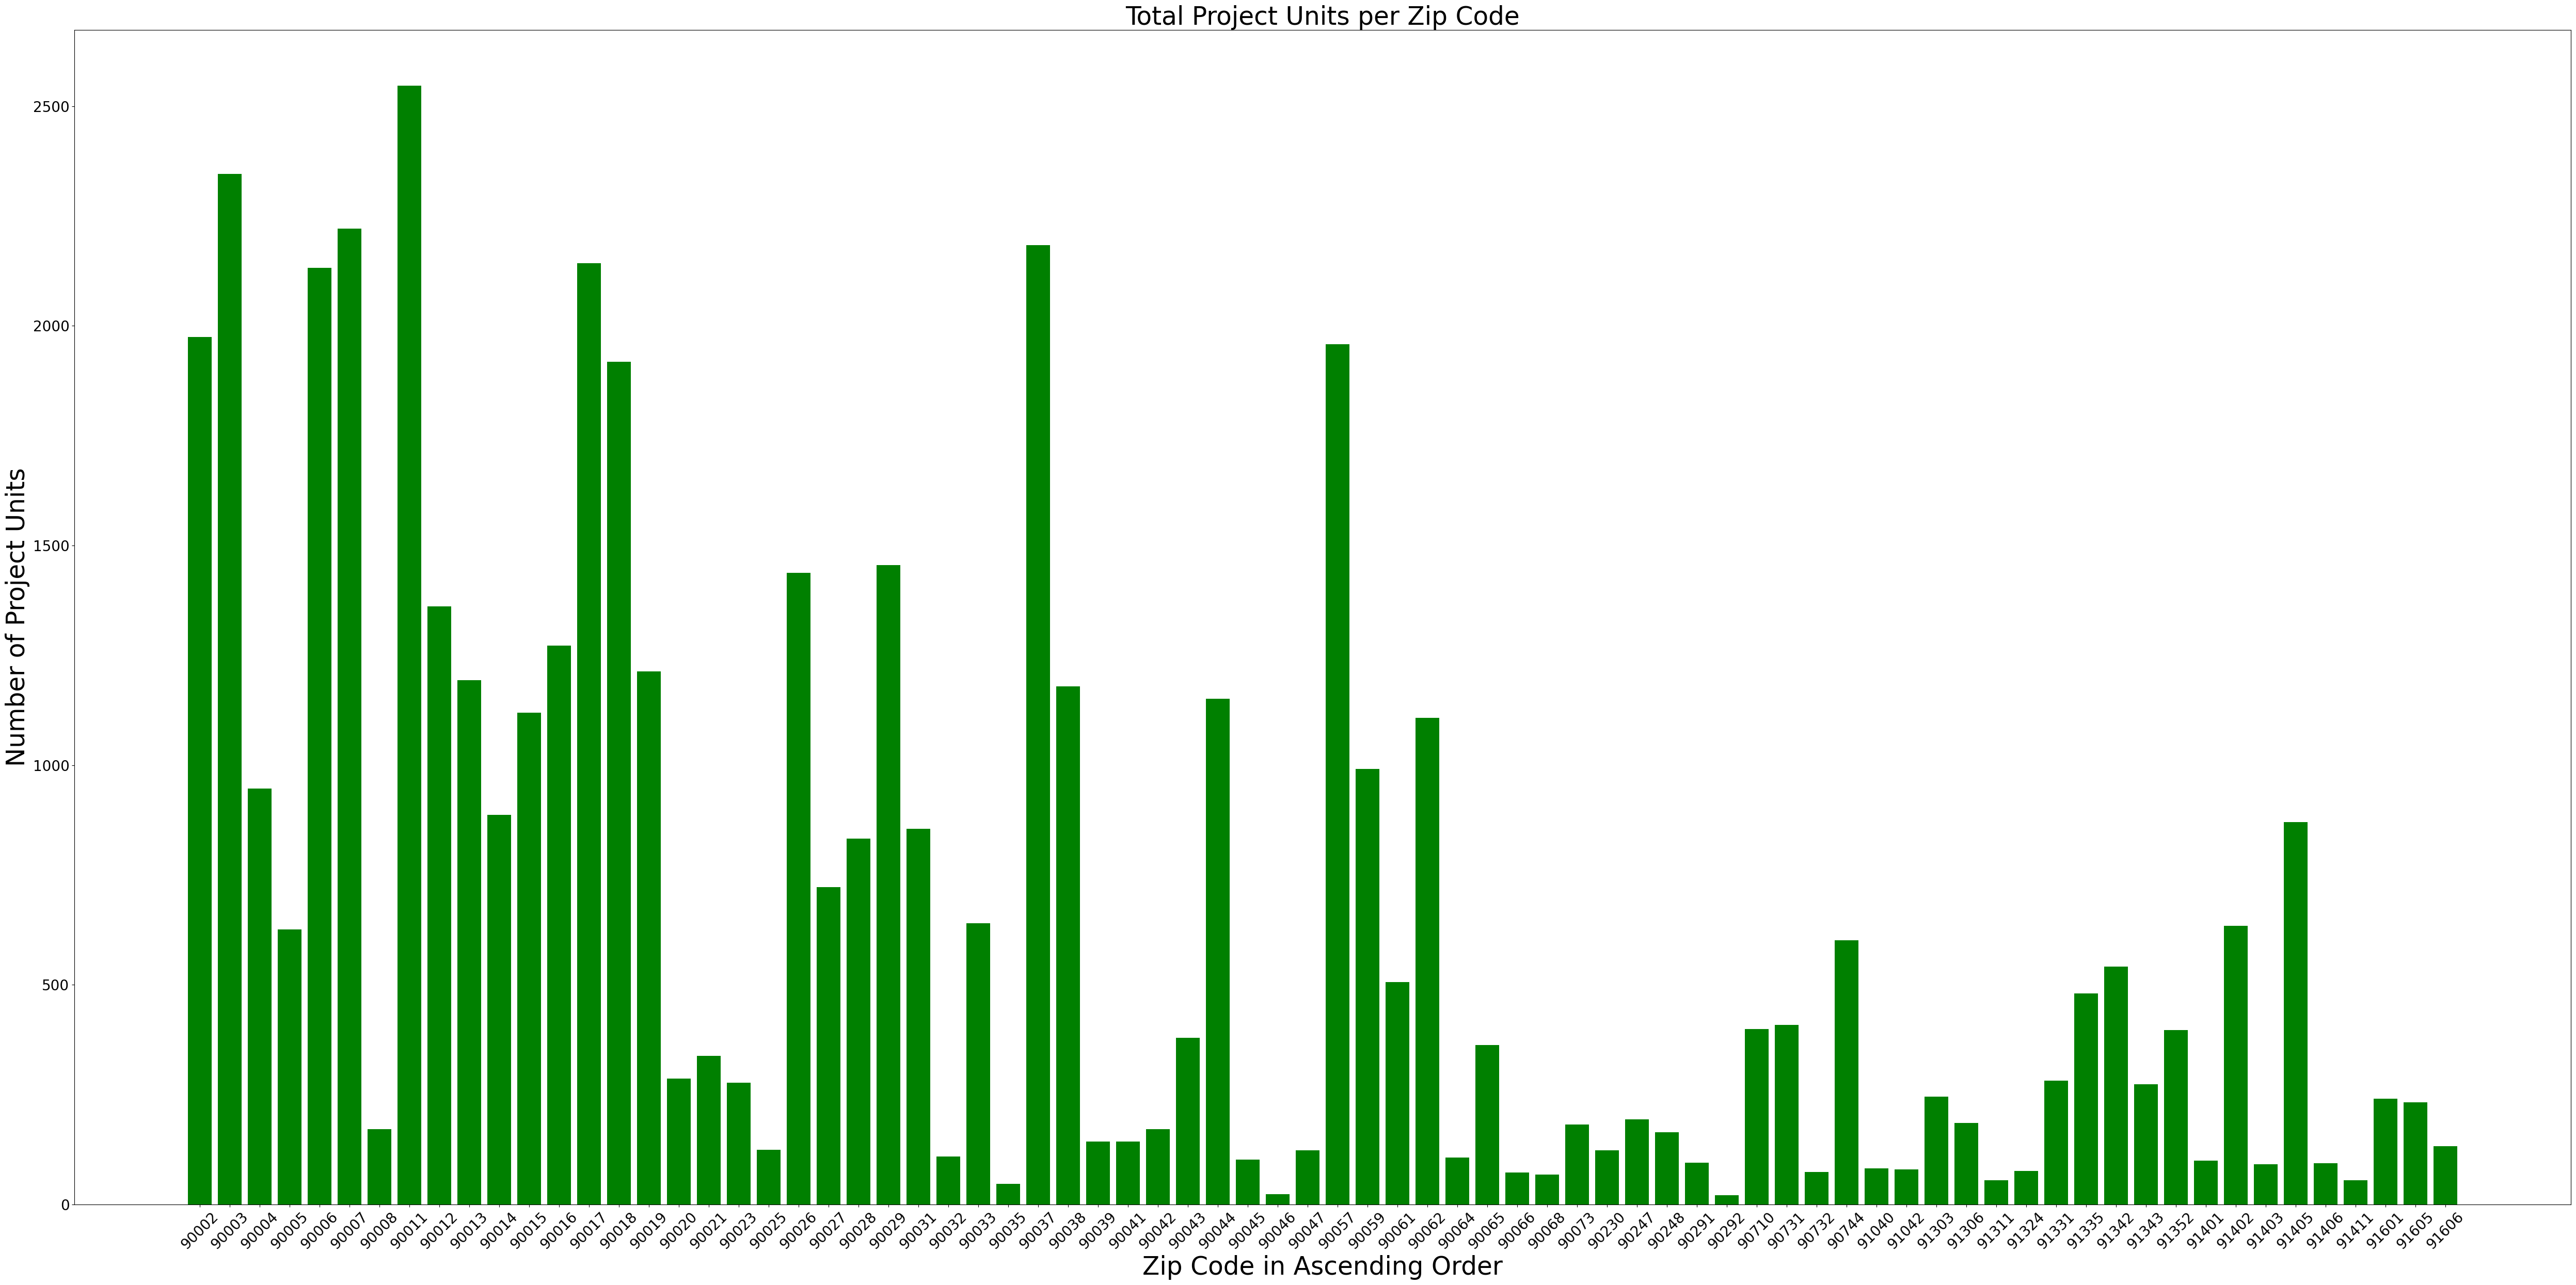

In [35]:
# [3]
housedf_units_per_zip = housedf.groupby('zip_code')['PROJECT TOTAL UNITS'].sum().reset_index().sort_values(by='zip_code')#by default it sorts in ascending order
x= housedf_units_per_zip['zip_code']
y= housedf_units_per_zip['PROJECT TOTAL UNITS']
plt.figure(figsize=(50,25))# setting the figure size
plt.bar(x,y, color='g')# bar plot
#no adding trend line to enhance visibililty
plt.xlabel("Zip Code in Ascending Order", fontsize=35)#setting x label
plt.ylabel('Number of Project Units', fontsize=35)#setting x label
plt.title('Total Project Units per Zip Code',fontsize=35)
plt.xticks(rotation=45, fontsize=20)# Rotating x-axis labels for readability without printing them
plt.yticks(fontsize=20)
plt.tight_layout()
plt.show()

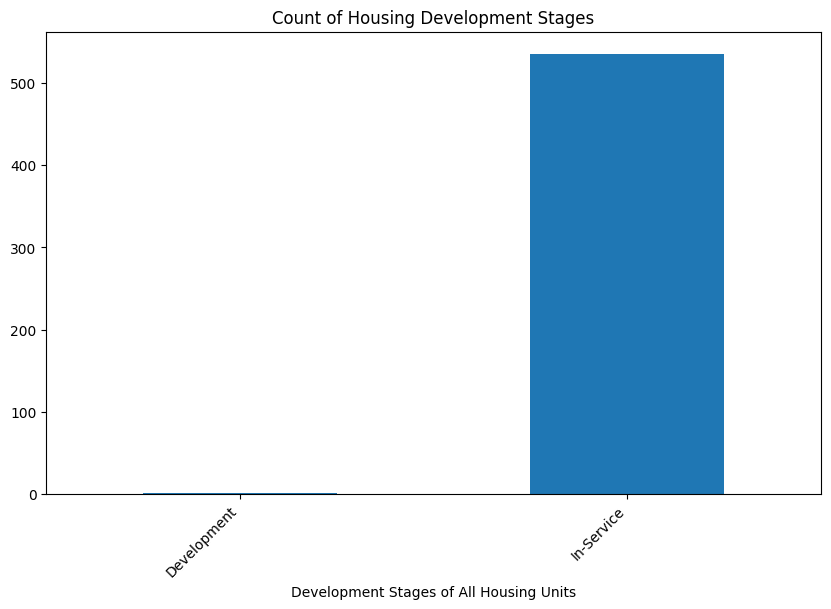

In [36]:
stage_counts = housedf.groupby("DEVELOPMENT STAGE")["DEVELOPMENT STAGE"].count()# create a series for counting the enties of column = DEVELOPMENT STAGE
plt.figure(figsize=(10, 6))
stage_counts.plot(kind='bar')
plt.xlabel("Development Stages of All Housing Units")
plt.title("Count of Housing Development Stages")
plt.xticks(rotation=45, ha='right')
plt.show()

In [37]:
house_type_counts = housedf.groupby("HOUSING TYPE")["HOUSING TYPE"].count().reset_index(name="count") # we need to make dataframe from series of Housing type counts

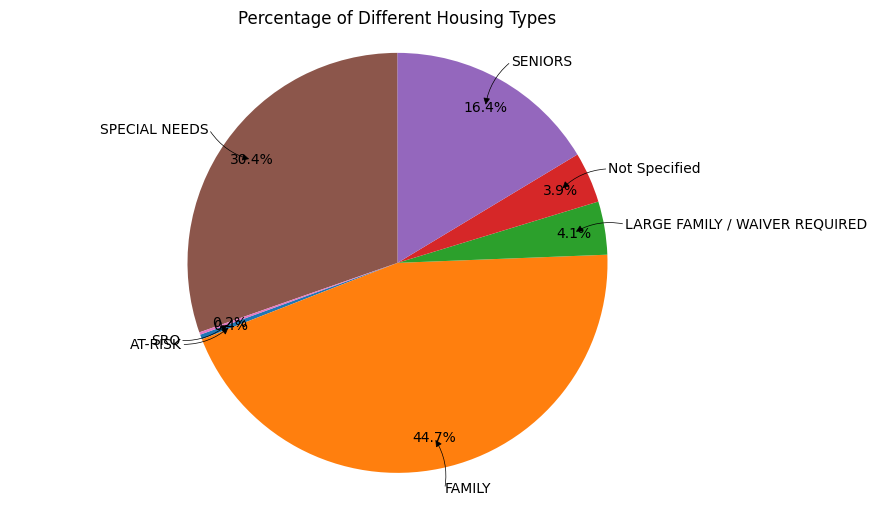

In [38]:
# [4]
x= house_type_counts["count"]
y= house_type_counts["HOUSING TYPE"]
plt.figure(figsize=(10, 6))
wedges, texts, autotexts = plt.pie(x,
    labels=y,
    autopct='%1.1f%%',# label each slice with its corresponding value in floating point upto one decimal point
    shadow=False,# adds shadow if we keep it true
    labeldistance=1.1,# how far the label outside the slice should be
    pctdistance=0.85,# how far from the center shold % values should be placed
    startangle=200
)

# Customize labels with narrower arrows
for i, (text, autotext) in enumerate(zip(texts, autotexts)):
    # Get the position of the text
    x_text, y_text = text.get_position()
    # Get the position of the autopct
    x_autotext, y_autotext = autotext.get_position()
    # Create a narrow arrow annotation
    plt.annotate(
        '',
        xy=(x_autotext, y_autotext),
        xytext=(x_text, y_text),
        arrowprops=dict(
            facecolor='black',
            edgecolor='black',
            arrowstyle='-|>',#line with a triangle head
            linewidth=0.5,  #thickness of the arrow
            connectionstyle='arc3,rad=0.2'  #curvature of the arrow
        )
    )
plt.title("Percentage of Different Housing Types")
plt.axis('equal')  #equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

In [39]:
houses_per_year = housedf.groupby("IN-SERVICE DATE")["PROJECT TOTAL UNITS"].sum().reset_index(name="PROJECT TOTAL UNITS")# sum each value of the column specified and make a dataframe from it

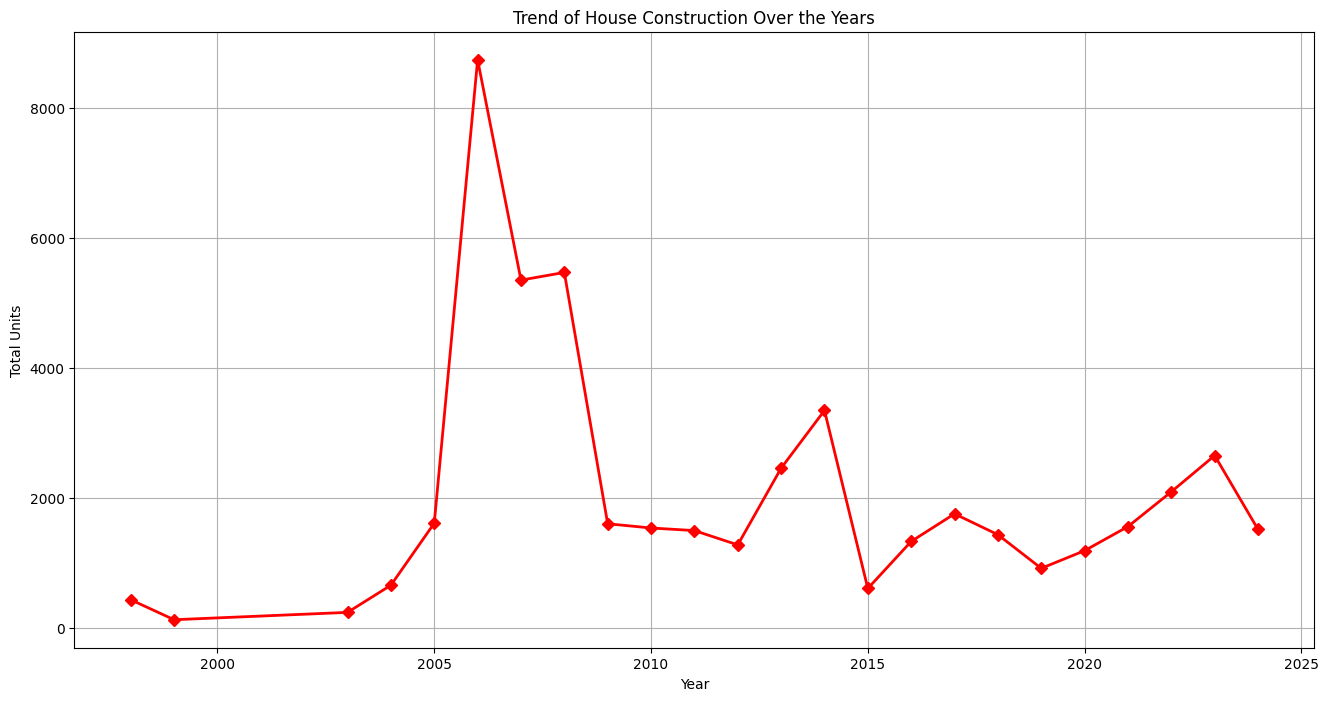

In [40]:
x= houses_per_year["IN-SERVICE DATE"]
y= houses_per_year["PROJECT TOTAL UNITS"]
plt.figure(figsize=(16, 8), dpi=100)

plt.plot(x,y, marker='D', linestyle='-', color='r', linewidth=2)#each data point should be marked with a dimond and connect them with a solid line of red color
plt.title('Trend of House Construction Over the Years')
plt.xlabel('Year')
plt.ylabel('Total Units')
plt.grid(True)# enables grid view
plt.show()

In [41]:
facility_names = restaurantdf.groupby("facility_name")["facility_name"].count().sort_values(ascending=False).reset_index(name="count")# count the categorical variable

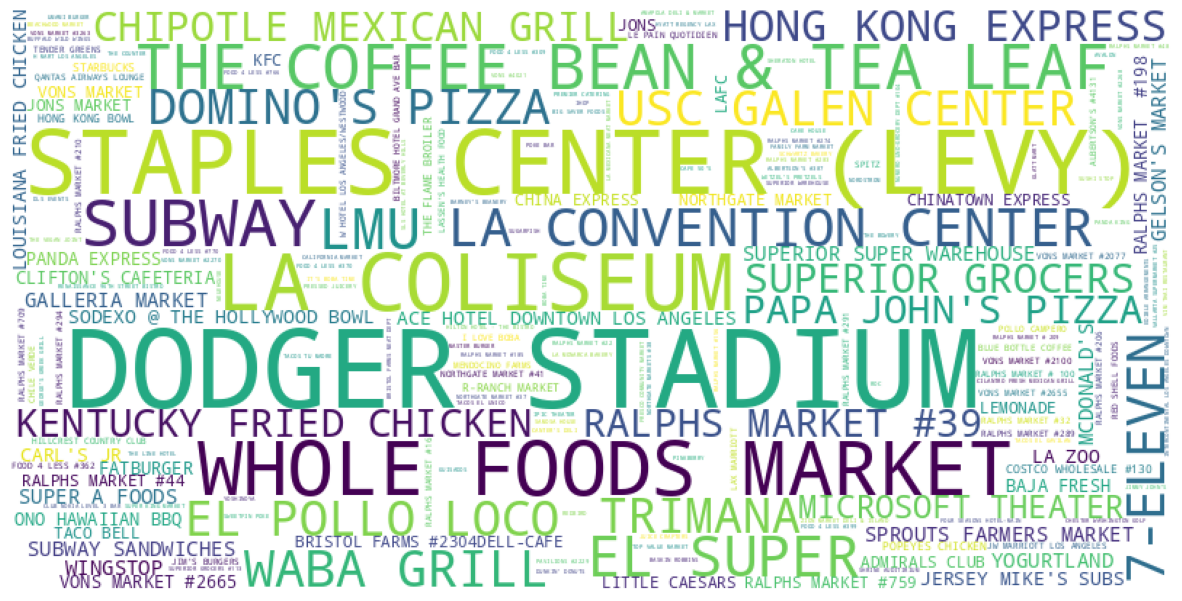

In [42]:
#[5]
# Create a dictionary with facility names as keys and counts as values
word_freq = dict(zip(facility_names['facility_name'], facility_names['count']))
# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)
# Display the word cloud using matplotlib
plt.figure(figsize=(15, 8))
plt.imshow(wordcloud)
plt.axis('off')#do not show axes for the word cloud
plt.show()

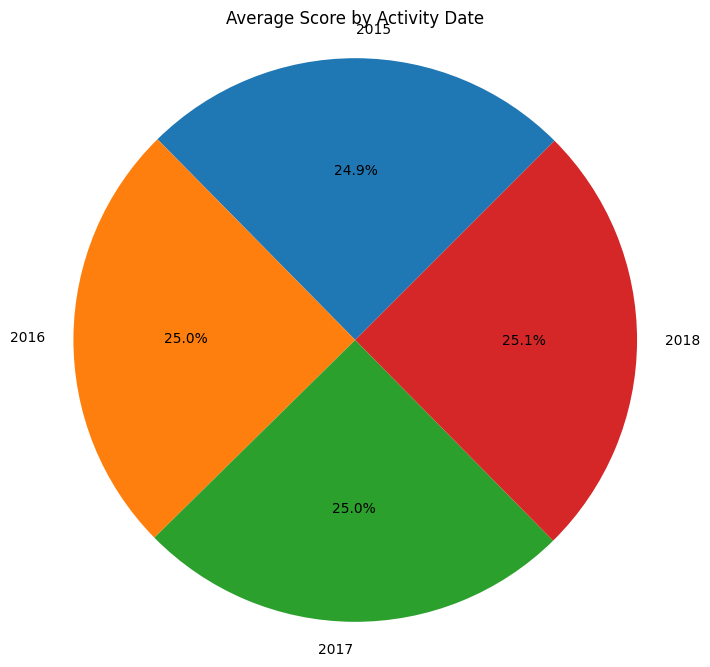

In [43]:
# [6]
# Calculate the mean score for each activity date
score_mean_by_date = restaurantdf.groupby(["activity_date"])["score"].mean()
# Create a pie chart
plt.figure(figsize=(8, 8))
plt.pie(score_mean_by_date, labels=score_mean_by_date.index, autopct='%1.1f%%', startangle=45)
plt.title('Average Score by Activity Date')
plt.axis('equal')  #Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

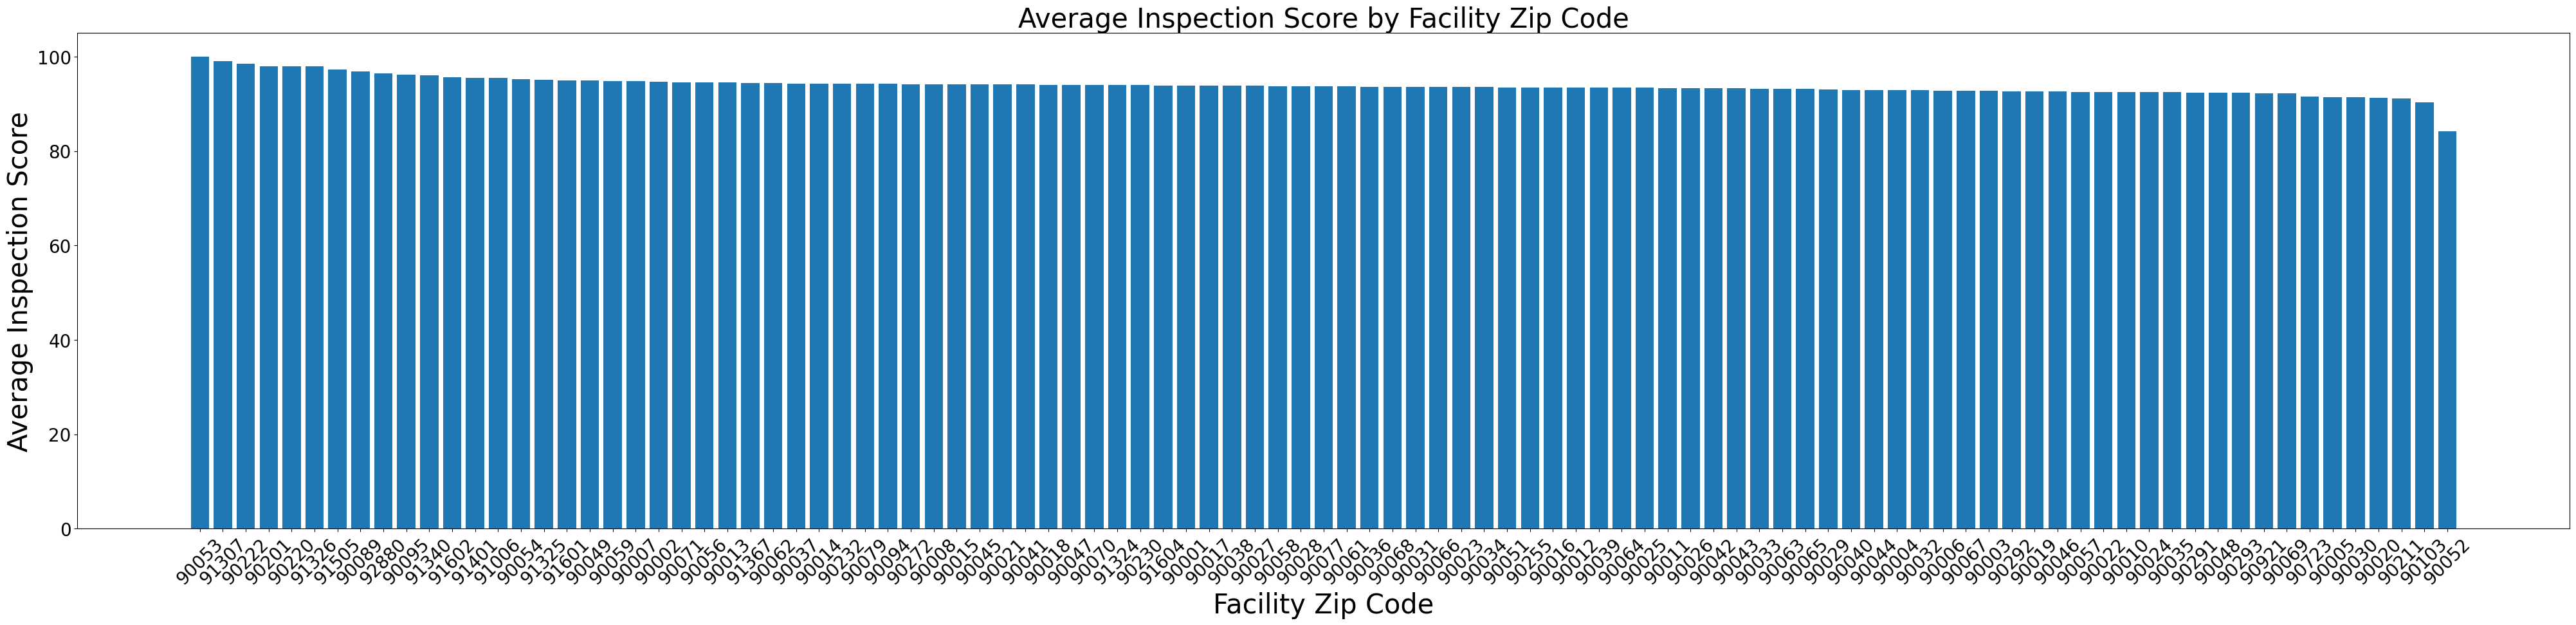

In [44]:
# [7]
# Calculate the mean score for each facility zip code
score_mean_by_zip = restaurantdf.groupby(["facility_zip"])["score"].mean().sort_values(ascending=False)
# Create a bar plot
plt.figure(figsize=(50, 10))
plt.bar(score_mean_by_zip.index, score_mean_by_zip.values)
plt.xlabel("Facility Zip Code",fontsize=30)
plt.ylabel("Average Inspection Score",fontsize=30)
plt.title("Average Inspection Score by Facility Zip Code",fontsize=30)
plt.xticks(rotation=45,fontsize=20)
plt.yticks(fontsize=20)
plt.show()

# c) Summarize each file by ZIP code using SQL

In [45]:
#[8]
# Connect to an SQLite database (or create one)
conn = sqlite3.connect('los_angeles_data.db')
# Create a cursor object to execute SQL queries
cursor = conn.cursor()
# Write DataFrames to SQL tables
restaurantdf.to_sql('restaurants', conn, if_exists='replace', index=False)
housedf.to_sql('housing', conn, if_exists='replace', index=False)

537

In [46]:
# [9]
query_housing = """
select
    zip_code,sum(case
            when `IN-SERVICE DATE` between 2015 AND 2016
            then `PROJECT TOTAL UNITS`
        end) as sum_units_2015_to_2016,
    sum(case
            when `IN-SERVICE DATE` between 2015 AND 2018
            then `PROJECT TOTAL UNITS`
        end) as sum_units_2015_to_2018
from
    housing
group by
    zip_code
order by zip_code asc
"""
housing_summary_df = pd.read_sql(query_housing, conn)# execute and load into a dataframe
housing_summary_df

,zip_code,sum_units_2015_to_2016,sum_units_2015_to_2018
0,90002,NaN,NaN
1,90003,49.0,49.0
2,90004,144.0,349.0
3,90005,NaN,283.0
4,90006,NaN,111.0
...,...,...,...
71,91406,NaN,NaN
72,91411,NaN,NaN
73,91601,NaN,NaN
74,91605,NaN,50.0


In [47]:
housing_summary_df = housing_summary_df[
    (housing_summary_df['sum_units_2015_to_2016'] > 0) &
    (housing_summary_df['sum_units_2015_to_2018'] > 0)]#we need to ilter out rows where both sums are zero because they are not of our interest- no new houses built
print(housing_summary_df)

   zip_code  sum_units_2015_to_2016  sum_units_2015_to_2018
1     90003                    49.0                    49.0
2     90004                   144.0                   349.0
7     90011                   315.0                   315.0
8     90012                    54.0                    54.0
9     90013                    69.0                   141.0
15    90019                    67.0                   115.0
16    90020                    67.0                   133.0
18    90023                    97.0                    97.0
21    90027                    40.0                   108.0
26    90033                    80.0                   130.0
28    90037                   125.0                   151.0
31    90041                    56.0                    56.0
34    90044                   156.0                   287.0
38    90057                   105.0                   154.0
43    90065                    49.0                   203.0
44    90066                    23.0     

#d) Join the files using SQL by ZIP code


In [48]:
query_restaurants = """
select facility_zip as zip_code,
 sum(case when `activity_date` between 2015 and 2016 then `score` end) as sum_scores_2015_to_2016,
 sum(case when `activity_date` between 2015 and 2018 then `score`end) as
 sum_scores_2015_to_2018

 from restaurants
 group by zip_code
 order by zip_code asc
"""
restaurants_summary_df = pd.read_sql(query_restaurants, conn)

In [49]:
restaurants_summary_df.to_sql('restaurants_summary', conn, if_exists='replace', index=False)#write dataframe to SQL table with the give name
housing_summary_df.to_sql('housing_summary', conn, if_exists='replace', index=False)#write dataframe to SQL table with the give name

22

In [50]:
query_join = """
select
    r.zip_code,
    r.sum_scores_2015_to_2016,
    r.sum_scores_2015_to_2018,
    h.sum_units_2015_to_2016,
    h.sum_units_2015_to_2018
from restaurants_summary as r
inner join
    housing_summary as h
on r.zip_code = h.zip_code
"""

joined_df = pd.read_sql(query_join, conn)# same as before to load into a dataframe

In [51]:
#[10]
# Create a boolean mask to identify rows where sum_units_2015_to_2016 equals sum_units_2015_to_2018
mask = joined_df['sum_units_2015_to_2018'] > joined_df['sum_units_2015_to_2016']
# Apply the mask to filter the DataFrame
joined_df = joined_df[mask]# we consider those zips where home has increased

In [52]:
joined_df

,zip_code,sum_scores_2015_to_2016,sum_scores_2015_to_2018,sum_units_2015_to_2016,sum_units_2015_to_2018
1,90004,65239.0,132242,144.0,349.0
4,90013,46170.0,103106,69.0,141.0
5,90019,69804.0,130800,67.0,115.0
6,90020,79318.0,169040,67.0,133.0
8,90027,88813.0,181098,40.0,108.0
9,90033,54307.0,108768,80.0,130.0
10,90037,59890.0,127668,125.0,151.0
12,90044,33543.0,72492,156.0,287.0
13,90057,44806.0,94362,105.0,154.0
14,90065,34887.0,70854,49.0,203.0


In [53]:
joined_df["score_before"] = joined_df["sum_scores_2015_to_2016"]/joined_df["sum_units_2015_to_2016"]

In [54]:
joined_df["score_after"] = joined_df["sum_scores_2015_to_2018"]/joined_df["sum_units_2015_to_2018"]

In [55]:
joined_df["score_diff"] = joined_df["score_before"] - joined_df["score_after"]

In [56]:
joined_df

,zip_code,sum_scores_2015_to_2016,sum_scores_2015_to_2018,sum_units_2015_to_2016,sum_units_2015_to_2018,score_before,score_after,score_diff
1,90004,65239.0,132242,144.0,349.0,453.048611,378.916905,74.131706
4,90013,46170.0,103106,69.0,141.0,669.130435,731.248227,-62.117792
5,90019,69804.0,130800,67.0,115.0,1041.850746,1137.391304,-95.540558
6,90020,79318.0,169040,67.0,133.0,1183.850746,1270.977444,-87.126697
8,90027,88813.0,181098,40.0,108.0,2220.325000,1676.833333,543.491667
9,90033,54307.0,108768,80.0,130.0,678.837500,836.676923,-157.839423
10,90037,59890.0,127668,125.0,151.0,479.120000,845.483444,-366.363444
12,90044,33543.0,72492,156.0,287.0,215.019231,252.585366,-37.566135
13,90057,44806.0,94362,105.0,154.0,426.723810,612.740260,-186.016450
14,90065,34887.0,70854,49.0,203.0,711.979592,349.034483,362.945109


# e) Formulate and test the hypothesis

* Null hypothesis: Although the number of neighborhoods are increased in a particular area of zip-code but **the mean value of inspection scores remain the same**:

  $H0:\mu_0 - \mu_1 = 0$

* Our alternate hypothesis: No, as the number of houses increases the mean value of inspection score of a particular zip-code decreases:

  $H1:\mu_0 - \mu_1>0$


**Right tailed two sample test for dependent samples**

In [57]:
#[11]
t_statistic, p_value = stats.ttest_rel(joined_df["score_before"],
                                       joined_df["score_after"],alternative='greater')# to indicate that before values are greater than those of after. it does 'before-after'

print(f'T-statistic: {t_statistic}')
print(f'P-value: {p_value}')
alpha = 0.05
if p_value <= alpha:
    print(f'Reject the null hypothesis (p <= {alpha}), significant difference.')
else:
    print(f'Fail to reject the null hypothesis ({p_value} > {alpha}), no significant difference.')

T-statistic: -0.014141023869415195
P-value: 0.5054870077185651
Fail to reject the null hypothesis (0.5054870077185651 > 0.05), no significant difference.


**Test conclusions:**
We failed to reject the reject null hypothesis. As it is found that there is no statistically significant difference  between the average inspection scores of before $(2015-2016)$ new houses and that of after$(2017-2018)$ new houses are built.

#2. Open-ended:
* Find some interesting data from Indian government data portal https://www.data.gov.in
and perform EDA, derive some insights using graphs, and perform a statistical test for an interesting
hypothesis.
* No need to use multiple files for this question, unless you want to do the extra work for your
own learning.

---

* Null hypothesis:
the averge number of crimes in the state of Karnataka-India, for the first quarter of the year 2024 is the the same as that of the year 2022.

  $H0:\mu_0 - \mu_1 = 0$

* Our alternate hypothesis: No. For that of 2024 ($\mu_1$), the average number of crimes has increased.

  $H1:\mu_0 - \mu_1<0$


**Left tailed two sample test for dependent samples**


Test type: dependent because both are for the karnathaka state of India during the two different periods.

In [58]:
file_path24 = '/content/drive/MyDrive/EE769_codes/Crimes_2024/CRIME_REVIEW_FOR_THE_MONTH_OF_APRIL_2024.csv'
df24 = pd.read_csv(file_path24)

file_path22 = '/content/drive/MyDrive/EE769_codes/Crimes_2022/CRIME_REVIEW_FOR_THE_MONTH_OF_APRIL_2022.csv'
df22 = pd.read_csv(file_path22)

#### i. Check for missing values, then decide to either remove those rows, or fill an imputed value

In [59]:
df22.isnull().sum()

,0
ACT,0
MAJOR HEAD,0
MINOR HEAD,0
During the current year upto the end of month under review,1
During the corresponding month of previous year,1
During the previous month,1
During the current month,0


In [60]:
#Drop the nulls becuase this column does not represent a single feature. It is not feasible to take the average of other crime types, other rows (independent features), to impute another type. If each of them were to be in a separate column then imputation would not mean biasness. Therefore, we drop them.
df22 = df22.dropna()
df22.isnull().sum()

,0
ACT,0
MAJOR HEAD,0
MINOR HEAD,0
During the current year upto the end of month under review,0
During the corresponding month of previous year,0
During the previous month,0
During the current month,0


In [61]:
df24.isnull().sum()

,0
Sl.No.,0
Heads of Crime,0
Major Heads,0
Minor Heads,53
During the current year upto the end of month under review,4
During the corresponding month of previous year,4
During the previous month,4
During the current month,4


In [62]:
# we drop the column "Minor Heads". Because, there are many null values dropping which will harm us due to losing rows of column of our interest which is "Major Heads". Since, other null values cannot be imputed we drop the corresponding rows.
df24 = df24.drop(columns=["Minor Heads"])

In [63]:
df24 = df24.dropna()

In [64]:
df24.isnull().sum()

,0
Sl.No.,0
Heads of Crime,0
Major Heads,0
During the current year upto the end of month under review,0
During the corresponding month of previous year,0
During the previous month,0
During the current month,0


#### ii. Check if the data types are as expected, else convert them



In [65]:
df22.dtypes

,0
ACT,object
MAJOR HEAD,object
MINOR HEAD,object
During the current year upto the end of month under review,float64
During the corresponding month of previous year,float64
During the previous month,float64
During the current month,int64


In [66]:
df22["During the current year upto the end of month under review"] = df22["During the current year upto the end of month under review"].astype(int)

In [67]:
df22["During the corresponding month of previous year"] = df22["During the corresponding month of previous year"].astype(int)

In [68]:
df22["During the previous month"] = df22["During the previous month"].astype(int)

In [69]:
df22.dtypes

,0
ACT,object
MAJOR HEAD,object
MINOR HEAD,object
During the current year upto the end of month under review,int64
During the corresponding month of previous year,int64
During the previous month,int64
During the current month,int64


In [70]:
df24.dtypes

,0
Sl.No.,int64
Heads of Crime,object
Major Heads,object
During the current year upto the end of month under review,float64
During the corresponding month of previous year,float64
During the previous month,float64
During the current month,float64


In [71]:
df24["During the current year upto the end of month under review"] = df24["During the current year upto the end of month under review"].astype(int)

In [72]:
df24["During the corresponding month of previous year"] = df24["During the corresponding month of previous year"].astype(int)

In [73]:
df24["During the previous month"] = df24["During the previous month"].astype(int)

In [74]:
df24["During the current month"] = df24["During the current month"].astype(int)

In [75]:
df24.dtypes

,0
Sl.No.,int64
Heads of Crime,object
Major Heads,object
During the current year upto the end of month under review,int64
During the corresponding month of previous year,int64
During the previous month,int64
During the current month,int64


#### iii. Check for unexpected entries in certain columns. Correct them if necessary and feasible.

Unexpected entries can be:
* spaces in certain columns
* range or a set of values specified by interval for a column where a single value is expected. This drawback can come in the object data-type format which we have already taken care of it (did not get an error while datatype conversion in above subtask)
* we will not remove 0s because they have a meaning

In [76]:
colsdf22_check =["ACT", "MAJOR HEAD", "MINOR HEAD"]
for colsdf22_check in colsdf22_check:# loops through each list item
  df22 = correctSpaces(df22, colsdf22_check)# drop that spaced row

In [77]:
colsdf24_check = ["Heads of Crime","Major Heads"]
for colsdf24_check in colsdf24_check:
  df24 = correctSpaces(df24, colsdf24_check)

#### Plots: derive some insights using graphs
* illustration of top 5 crimes of each year's quarter
* trend of total crimes for the month of April of four years

In [78]:
top5_22 = df22.groupby("MAJOR HEAD")["During the current year upto the end of month under review"].sum().sort_values(ascending=False).reset_index().head(5)
top5_24 = df24.groupby("Major Heads")["During the current year upto the end of month under review"].sum().sort_values(ascending=False).reset_index().head(5)

In [79]:
crimes24 = top5_24["Major Heads"]
crime_count24 = top5_24["During the current year upto the end of month under review"]
crimes22 = top5_22["MAJOR HEAD"]
crime_count22 = top5_22["During the current year upto the end of month under review"]

<ipython-input-81-dc37dc091fe9>:11: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


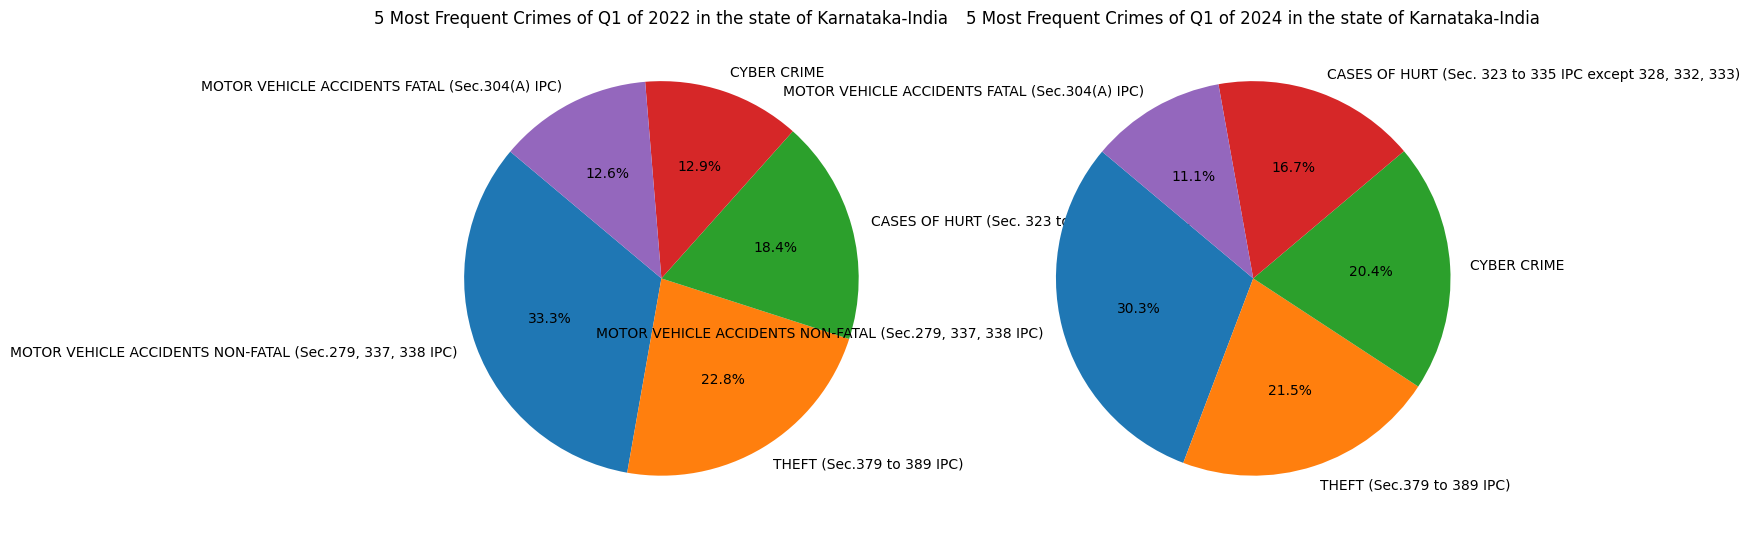

In [81]:
#[12]
# Plotting the data
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7))
# Plotting pie chart for year 2022
ax1.pie(crime_count22, labels=crimes22,autopct='%1.1f%%', startangle=140)
ax1.set_title('5 Most Frequent Crimes of Q1 of 2022 in the state of Karnataka-India')

# Plotting pie chart for year 2024
ax2.pie(crime_count24, labels=crimes24, startangle=140,autopct='%1.1f%%')
ax2.set_title('5 Most Frequent Crimes of Q1 of 2024 in the state of Karnataka-India')
plt.tight_layout()
plt.show()

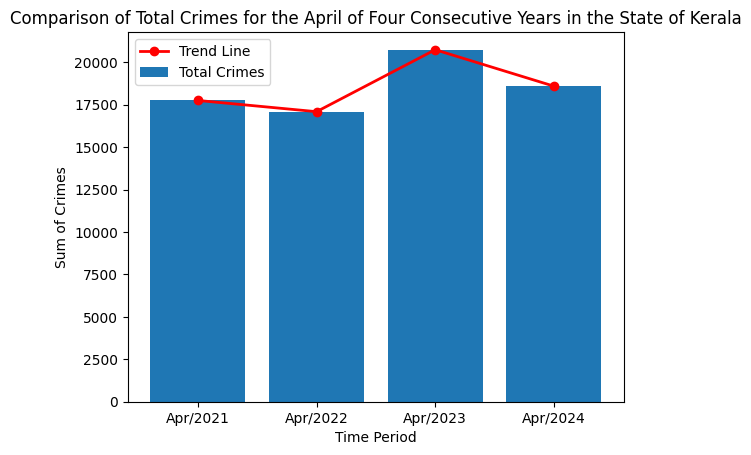

In [82]:
# Data
apr_21 = df22["During the previous month"].sum()
apr_22 = df22["During the current month"].sum()
apr_23 = df24["During the previous month"].sum()
apr_24 = df24["During the current month"].sum()

# X-axis labels
time_periods = ['Apr/2021', 'Apr/2022', 'Apr/2023', 'Apr/2024']
values = [apr_21, apr_22, apr_23, apr_24]

# Plotting the bar chart
plt.bar(time_periods, values, label='Total Crimes')
########[13]########
# Adding a line plot on top of the bar chart
plt.plot(time_periods, values, marker='o', color='r', linestyle='-', linewidth=2, label='Trend Line')

plt.xlabel('Time Period')
plt.ylabel('Sum of Crimes')
plt.title('Comparison of Total Crimes for the April of Four Consecutive Years in the State of Kerala')
plt.legend()
# Display the plot
plt.show()

#### statistical test

In [83]:
df22_grouped = df22.groupby("MAJOR HEAD").size().reset_index(name="Particular Crime Count").sort_values(by="Particular Crime Count", ascending=False)# counts each particular crime and makes a dataframe of sorted values of crime count
print(df22_grouped)

                                            MAJOR HEAD  Particular Crime Count
92                          KARNATAKA STATE LOCAL ACTS                      49
162                         THEFT (Sec.379 to 389 IPC)                      27
51   DEATHS DUE TO RASHNESS/NEGLIGENCE (Sec.304(A) ...                      25
102                           Murder (Sec.302/303 IPC)                      25
93   KIDNAPPING AND ABDUCTION (Sec.360, 361, 363 to...                      24
..                                                 ...                     ...
67                 FALSE EVIDENCE (Sec.191 to 205 IPC)                       1
65               Exposure & abandonment (Sec. 317 IPC)                       1
60         Dowry Death-by other Means (Sec.304(B) IPC)                       1
59             Dowry Death-by burning\n(Sec.304-B IPC)                       1
169                         of Girls - Immoral Purpose                       1

[170 rows x 2 columns]


In [84]:
df24_grouped = df24.groupby("Major Heads").size().reset_index(name="Particular Crime Count").sort_values(by="Particular Crime Count", ascending=False)#counts each particular crime and makes a dataframe of sorted values of crime count for dataframe of 2024
print(df24_grouped)

                                           Major Heads  Particular Crime Count
92                          KARNATAKA STATE LOCAL ACTS                      49
13   ATTEMPT TO CULPABLE HOMICIDE NOT AMOUNTING TO ...                      35
0              ADULTERATION (Sec. 272, 273 to 276 IPC)                      31
156                         THEFT (Sec.379 to 389 IPC)                      27
93   KIDNAPPING AND ABDUCTION (Sec.360, 361, 363 to...                      25
..                                                 ...                     ...
88                           KARNATAKA POLICE ACT 1964                       1
87                           KARNATAKA POLICE ACT 1963                       1
86                                Juvenile Justice Act                       1
85   Insulting modesty (Eve-Teasing) (Sec.294 & 509...                       1
97   MISCHIEF (Sec.427 to 440 except 434, 435, 436,...                       1

[161 rows x 2 columns]


In [85]:
if len(df22_grouped) != len(df24_grouped):# for testing the lengths of both dataframe must be the identical
  minlen = min(len(df24_grouped),len(df22_grouped))# whichever dataframe has minimum length take that
  print(minlen)
  df24_grouped = df24_grouped.head(minlen)# till the minimum length found above line for both
  df22_grouped = df22_grouped.head(minlen)

161


In [86]:
print(len(df24_grouped),len(df22_grouped))

161 161


In [87]:
#perform the t-test for dependent samples
t_statistic, p_value = stats.ttest_rel(df22_grouped["Particular Crime Count"],
                                       df24_grouped["Particular Crime Count"],alternative='less')

print(f'T-statistic: {t_statistic}')
print(f'P-value: {p_value}')
alpha = 0.05#signficance level
if p_value <= alpha:
    print(f'Reject the null hypothesis. Because, ({p_value} <= {alpha}), significant difference.')
else:
    print(f'Fail to reject the null hypothesis. Because, ({p_value} >{alpha}), no significant difference.')

T-statistic: -1.7158731936134566
P-value: 0.0440604249905604
Reject the null hypothesis. Because, (0.0440604249905604 <= 0.05), significant difference.


**Test conclusions:**
There is significant evidence to reject the null hypothesis. As the test has shown, the average number of crimes for the Q1 of 2024 in the state of Karnataka-India has increased significantly compared to that of 2022.

#References

######[1]: https://www.simplilearn.com/data-imputation-article#:~:text=8.,now%20learn%20about%20Multiple%20imputations
[2]: prompt to Gemini of google collab:

housedf["SITE ADDRESS"]
check if the last 5 characters are numeric values.
if true then create a column with all those numeirc values in one column
else print nondigit

[3]:

Past python notebooks shared by Prof. Amit Sethi but major modifications done by 22D0382.

[4]: prompt to ChatGPT


plt.figure(figsize=(10, 6))
plt.pie(house_type_counts["count"], labels=house_type_counts["HOUSING TYPE"], autopct='%1.1f%%', shadow=False,labeldistance=1.1,pctdistance=0.85, startangle=200)
plt.title("Percentage of Different Housing Types")
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()
use arrow like this
(percentatage) label<------ lice
make the arrow narrow because some lables are still overriding each other
so solve it.
write the percentage bellow the label outside the slice.

[5] prompt to ChatGPTwith minor modifications by 22D0382:

I need to visualize the word cloud of restaurant names based on their frequency of occurrence.
Please help me to do so in python.
Following is a sample of my data frame:
facility_name	count
0	DODGER STADIUM	464
1	STAPLES CENTER (LEVY)	290
2	LA COLISEUM	225

[6] prompt to Gemini of google colab:
restaurantdf.groupby(["activity_date"])["score"].mean()
Please visualize its pie plot

[7] prompt to Gemini of google colab:
restaurantdf.groupby(["facility_zip"])["score"].mean()
Please help me visualize this to understand the trend of average inspection score across the zipcodes

[8] ChatGPT Prompt:
how can i use sql in python.
do I have to install sqlserver and then make database from my csv and then connect python with SQL and then run query

[9] https://www.w3schools.com/sql/sql_join.asp

[10] prompt to google colab's Gemini: in joined_df
if sum_units_2015_to_2016==sum_units_2015_to_2018
remove the row

[11] https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_rel.html

[12] ChatGPT prompt:
top 5 products in 2022
top 5 products in 2024
how to show them in one bar chart color while coded.Please note that the top 5 of each year is different.

[13] ChatGPT Promt:
apr_21= df22["During the previous month"].sum()
apr_22= df22["During the current month"].sum()
apr_23= df24["During the previous month"].sum()
apr_24= df24["During the current month"].sum()
plt.bar(['Apr/2021', 'Apr/2022', 'Apr/2023','Apr/2024'], [apr_21,apr_22,apr_23,apr_24])
plt.xlabel('Time Period')
plt.ylabel('Sum of Crimes')
plt.title('Comparison of total crimes for the month of Apr of four consecutive years in the state of Kerala')
plt.show()
just tell me
how should also draw a line one them to show the distribution